In [43]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import classification_report, f1_score
import warnings
from PIL import Image
import face_recognition
from scipy import misc
from sklearn.datasets import fetch_olivetti_faces
import seaborn as sns
sns.set_context("paper")
sns.set(style='darkgrid', font_scale=1.25)
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 4, 4

image_shape = (64, 64)
#set no. of rows that the images will be resized.
k1=image_shape[0]
#set no. of columns that the images will be resized.
k2=image_shape[1]

treshold = 7.5
train_path = 'train'
test_path = 'test'

In [48]:
def norm_2(v1, v2):
    return np.linalg.norm(v1-v2, 2)

def get_imlist(path):
    """ Returns a list of filenames for all png images in a directory"""
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.png') or f.endswith('.jpg')]

def showfig(image, ax=None):
    if not ax:
        imgplot=imshow(image, cmap='gray')
        imgplot.axes.get_xaxis().set_visible(False)
        imgplot.axes.get_yaxis().set_visible(False)
    if ax:
        ax.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
# Load the jpg file into a numpy array
def face_detect(path):
    image = face_recognition.load_image_file(path)

    # Find all the faces in the image using the default HOG-based model.
    # This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
    # See also: find_faces_in_picture_cnn.py
    face_locations = face_recognition.face_locations(image)

    #print("I found {} face(s) in this photograph.".format(len(face_locations)))
    faces = np.array([])
    for face_location in face_locations:

        # Print the location of each face in this image
        top, right, bottom, left = face_location
        #print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

        # You can access the actual face itself like this:
        face_image = image[top:bottom, left:right]
        pil_image = Image.fromarray(face_image).convert('L')
        pil_image1 = misc.imresize(pil_image, [k1,k2])
        if not faces.shape[0]:
            faces = np.array(pil_image1).flatten()
        else:
            faces = np.vstack([faces, np.array(pil_image1).flatten()])
        return faces
    
def scale(vec):
    return vec/vec.max()#/255
    
def populate_train(path_train, faces_images, faces_ids):
    filenames = get_imlist(path_train)
    filenames = np.array(filenames)
    n=len(filenames)
    new_faces = face_detect(filenames[0])
    new_faces = scale(new_faces)
    for i in range(1,n):
        temp = face_detect(filenames[i])
        temp = scale(temp)
        new_faces = np.vstack([new_faces,temp])
        
    cnt = new_faces.shape[0]
    new_target = np.array([np.max(faces_ids)+1 for _ in range(cnt)])
    faces_images = np.vstack([faces_images,new_faces])
    faces_ids = np.concatenate((faces_ids,new_target), axis=None)

    fig = plt.figure(figsize=(16, 4))
    plt.title('The Added faces')
    plt.axis("off")
    for j in range(cnt):
        fig.add_subplot(1,cnt,j+1)
        showfig(new_faces[j,:].reshape(image_shape))
    return faces_images, faces_ids

class Face_Detector:
    def __init__(self, face_mtx, target):
        self.mean_face = np.mean(face_mtx, axis=0)
        self.Matrix = face_mtx - self.mean_face
        self.target = target
        self.face_basis = None
        self.train_proj = None
        self.errs = None
    
    def fit(self):
        B = np.copy(self.Matrix.T)
        r = np.linalg.matrix_rank(B)
        u, s, vh = np.linalg.svd(B)
        self.face_basis = u[:,:r]
        self.train_proj = self.face_basis.T.dot(B)
    
    def predict(self, new_face, treshold):
        test_f = new_face - self.mean_face
        test_proj = self.face_basis.T.dot(test_f)
        self.errors = np.array([], dtype=float)
        
        for i in range(self.train_proj.shape[1]):
            e = norm_2(test_proj.flatten(), self.train_proj[:,i].flatten())
            self.errors = np.append(self.errors, e)
        min_distance_index = np.argmin(self.errors)

        error = self.errors[min_distance_index]
        if error > treshold:
            return -1, error
        return self.target[min_distance_index], error
    
def load_image(path):  
    new_face = face_detect(path)
    new_face = scale(new_face)
    return new_face

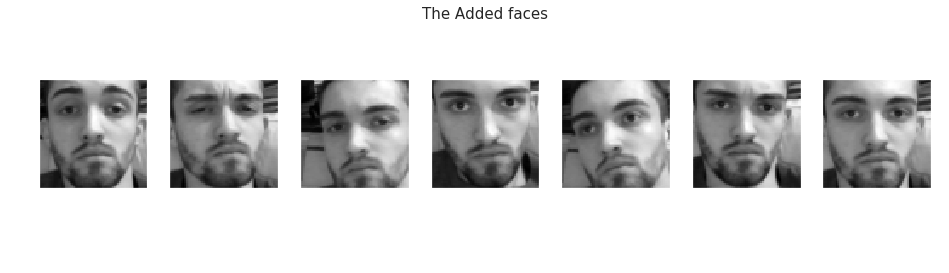

In [45]:
faces = fetch_olivetti_faces(shuffle=False, random_state=432542)
faces_images = faces.data
faces_images1 = np.copy(faces_images)
faces_ids = faces.target

faces_images, faces_ids = populate_train(train_path, faces.data, faces.target)

detector = Face_Detector(faces_images, faces_ids)
detector.fit()

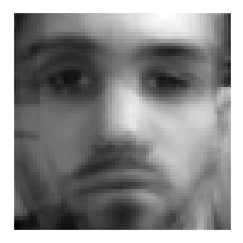

In [46]:
test_files = get_imlist(test_path)
image = None
for img in test_files:
    if image is not None:
        image += load_image(img)
    else:
        image = load_image(img)
image = image/len(test_files)
showfig(image.reshape(image_shape))

7.3999483872053835


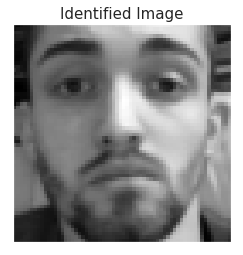

In [47]:
predicted_id, error = detector.predict(image, treshold=treshold)
print(error)
if predicted_id != -1:
    predicted_index = np.argwhere(faces_ids==predicted_id)[0][0]
    predicted_face = faces_images[predicted_index, :]
    identified = predicted_face.reshape(image_shape)
    fig = plt.figure(figsize=[4,4])
    plt.title('Identified Image')
    showfig(identified)
else:
    print('Not recognized')